<a href="https://colab.research.google.com/github/AfnanAbdul/TuringLens/blob/main/notebooks/finetune_RoBERTa_LoRA_RAID_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

# Fine-tuning RoBERTa-LoRA for AI Text Detection on RAID Abstracts Dataset

In this notebook, we further fine-tune a RoBERTa model with Low-Rank Adaptation (LoRA) that was initially trained on the Kaggle LLM-generated text detection dataset (`finetune_roberta_lora.ipynb`). We now adapt this pre-trained model specifically for academic abstracts using the RAID (Robust AI-generated text Detection) dataset.

## Key Challenges Addressed
Our evaluation of the initial model on an external dataset (RAID abstract domain) revealed a significant bias in predictions: while it excelled at detecting AI-generated text (97.3% accuracy), it struggled with correctly identifying human-written text (16.8% accuracy). This is a common challenge in AI detection systems due to dataset imbalances and the increasing sophistication of AI text generators.

## Improvements
We implement several strategies to address this classification bias:

1. **Balanced Dataset Construction**: Created a balanced dataset with equal representation of human texts, regular AI-generated texts, and adversarial AI examples (1,766 samples of each category).

2. **Aggressive Class Weighting**: Applied a 10:1 weighting ratio (5.0 for human class, 0.5 for AI class) to heavily penalize the model for misclassifying human text as AI-generated.

3. **Human-Focused Evaluation Metrics**: Added specific metrics to track human text detection performance:
   - `human_accuracy`: Measures success rate on human texts
   - `human_false_positive_rate`: Tracks how often human text is wrongly labeled as AI
   - `balanced_accuracy`: Provides a fairer assessment across both classes

4. **Optimized Training Configuration**:
   - Set `human_accuracy` as the primary metric to optimize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU")

GPU available: Tesla T4
Number of GPUs: 1


## Loading the RAID dataset

In [ ]:
# Load only the abstract domain data
print("Loading RAID abstract domain...")
raid = load_dataset("liamdugan/raid", split="train").filter(lambda x: x["domain"] == "abstracts")

Loading RAID abstract domain...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.8G [00:00<?, ?B/s]

extra.csv:   0%|          | 0.00/3.71G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating extra split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

Filter:   0%|          | 0/5615820 [00:00<?, ? examples/s]

## Pre-processing & splitting the dataset

In [ ]:
abstracts_df = raid.to_pandas()
print(f"Total abstract examples: {len(abstracts_df)}")

Total abstract examples: 741720


convert into a binary classification problem:


*   Label 0: Human-written content
*   Label 1: AI-generated content

In [ ]:
# Create a binary label (0 for human, 1 for AI)
abstracts_df['label'] = abstracts_df['model'].apply(lambda x: 0 if x == 'human' else 1)

In [ ]:
abstracts_df.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation,label
0,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,human,None,None,none,abstracts,FUTURE-AI: Guiding Principles and Consensus Re...,None,The recent advancements in artificial intellig...,0
1,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,human,None,None,none,abstracts,EdgeFlow: Achieving Practical Interactive Segm...,None,High-quality training data play a key role in ...,0
2,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,human,None,None,none,abstracts,Semi-supervised Contrastive Learning for Label...,None,The success of deep learning methods in medica...,0
3,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,human,None,None,none,abstracts,Combo Loss: Handling Input and Output Imbalanc...,None,Simultaneous segmentation of multiple organs f...,0
4,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,human,None,None,none,abstracts,Attention-Based 3D Seismic Fault Segmentation ...,None,Detection faults in seismic data is a crucial ...,0


The dataset contains both regular and adversarial examples:


*   Regular examples are standard human or AI-generated text
*   Adversarial examples are AI-generated texts designed to be harder to detect

In [ ]:
# Split by adversarial/non-adversarial
regular_abstracts = abstracts_df[abstracts_df['attack'] == 'none']
adversarial_abstracts = abstracts_df[abstracts_df['attack'] != 'none']

In [ ]:
print(f"Regular abstracts: {len(regular_abstracts)}")
print(f"Adversarial abstracts: {len(adversarial_abstracts)}")
print(f"Human examples in regular abstracts: {len(regular_abstracts[regular_abstracts['model'] == 'human'])}")
print(f"AI examples in regular abstracts: {len(regular_abstracts[regular_abstracts['model'] != 'human'])}")

Regular abstracts: 61810
Adversarial abstracts: 679910
Human examples in regular abstracts: 1766
AI examples in regular abstracts: 60044


The data is split into train/validation/test sets (70/15/15 split)

In [ ]:
# Split the data into train, validation, and test sets (70/15/15 split)
# First, separate into regular and adversarial sets
regular_human = regular_abstracts[regular_abstracts['model'] == 'human']
regular_ai = regular_abstracts[regular_abstracts['model'] != 'human']

# Split regular examples into train, validation, and test
# Human data
# train_human, temp_human = train_test_split(regular_human, test_size=0.3, random_state=42)
# val_human, test_human = train_test_split(temp_human, test_size=0.5, random_state=42)

# AI data (regular)
# train_ai, temp_ai = train_test_split(regular_ai, test_size=0.3, random_state=42)
# val_ai, test_ai = train_test_split(temp_ai, test_size=0.5, random_state=42)

# Split adversarial examples (only for AI) similar to regular AI examples
# adv_train, adv_temp = train_test_split(adversarial_abstracts, test_size=0.3, random_state=42)
# adv_val, adv_test = train_test_split(adv_temp, test_size=0.5, random_state=42)

# Combine the splits
# train_df = pd.concat([train_human, train_ai, adv_train])
# val_df = pd.concat([val_human, val_ai, adv_val])
# test_df = pd.concat([test_human, test_ai, adv_test])

Using a sample of the dataset (1,766 human + 1,766 regular AI + 1,766 adversarial AI)

In [ ]:
sample_size_regular_human = 1766  # Number of human examples
sample_size_regular_ai = 1766     # Number of AI examples (regular)
sample_size_adversarial = 1766    # Number of adversarial examples

# Sample regular human abstracts
sampled_regular_human = regular_human.sample(n=min(sample_size_regular_human, len(regular_human)), random_state=42)

# Sample regular AI abstracts
sampled_regular_ai = regular_ai.sample(n=min(sample_size_regular_ai, len(regular_ai)), random_state=42)

# Sample adversarial abstracts
sampled_adversarial = adversarial_abstracts.sample(n=min(sample_size_adversarial, len(adversarial_abstracts)), random_state=42)

# Now split these sampled datasets into train/val/test
# Human data
train_human, temp_human = train_test_split(sampled_regular_human, test_size=0.3, random_state=42)
val_human, test_human = train_test_split(temp_human, test_size=0.5, random_state=42)

# AI data (regular)
train_ai, temp_ai = train_test_split(sampled_regular_ai, test_size=0.3, random_state=42)
val_ai, test_ai = train_test_split(temp_ai, test_size=0.5, random_state=42)

# Adversarial examples
adv_train, adv_temp = train_test_split(sampled_adversarial, test_size=0.3, random_state=42)
adv_val, adv_test = train_test_split(adv_temp, test_size=0.5, random_state=42)

# Combine the splits
train_df = pd.concat([train_human, train_ai, adv_train])
val_df = pd.concat([val_human, val_ai, adv_val])
test_df = pd.concat([test_human, test_ai, adv_test])

In [ ]:
# Shuffle each split
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print split sizes
print(f"\nTrain set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Train set: 3708 samples
Validation set: 795 samples
Test set: 795 samples


In [ ]:
# Print label distribution in each split
print(f"\nTrain set label distribution:\n{train_df['label'].value_counts()}")
print(f"Validation set label distribution:\n{val_df['label'].value_counts()}")
print(f"Test set label distribution:\n{test_df['label'].value_counts()}")


Train set label distribution:
label
1    2428
0    1280
Name: count, dtype: int64
Validation set label distribution:
label
1    521
0    274
Name: count, dtype: int64
Test set label distribution:
label
1    525
0    270
Name: count, dtype: int64


There are many more AI-generated texts (label 1) than human-written texts (label 0)

Adding a higher weight to the human class to penalize misclassifications more heavily ...

In [ ]:
human_weight = 5.0  # Significantly higher weight for human class (was ~1.44)
ai_weight = 0.5     # Lower weight for AI class (was ~0.76)

weights_dict = {0: human_weight, 1: ai_weight}
print(f"Class weights: {weights_dict}")

# Keep the rest the same
class_weights_tensor = torch.FloatTensor([weights_dict[0], weights_dict[1]])

Class weights: {0: 5.0, 1: 0.5}


## Load our previously finetuned RoBERTa LoRA model

In [ ]:
# Load pre-trained model and tokenizer
print("\nLoading pre-trained RoBERTa-LoRA model...")
model_path = "/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-ai-detector"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


Loading pre-trained RoBERTa-LoRA model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
def preprocess(examples):
    return tokenizer(
        examples["generation"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

In [ ]:
tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_val = val_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3708 [00:00<?, ? examples/s]

Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/795 [00:00<?, ? examples/s]

In [ ]:
class WeightedLoss:
    def __init__(self, class_weights):
        self.class_weights = class_weights

    def __call__(self, logits, labels):
        # Move weights to same device as logits
        if self.class_weights.device != logits.device:
            self.class_weights = self.class_weights.to(logits.device)

        # Use CrossEntropyLoss with weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        return loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Overall metrics
    metrics = {}
    metrics["accuracy"] = accuracy_score(labels, predictions)
    metrics["precision"] = precision_score(labels, predictions)
    metrics["recall"] = recall_score(labels, predictions)
    metrics["f1"] = f1_score(labels, predictions)

    # Class-specific metrics
    human_indices = np.where(labels == 0)[0]
    ai_indices = np.where(labels == 1)[0]

    # Add human_false_positive_rate
    if len(human_indices) > 0:
        human_preds = predictions[human_indices]
        metrics["human_accuracy"] = np.mean(human_preds == 0)
        metrics["human_false_positive_rate"] = np.mean(human_preds == 1)

    # Add AI detection accuracy
    if len(ai_indices) > 0:
        ai_preds = predictions[ai_indices]
        metrics["ai_accuracy"] = np.mean(ai_preds == 1)

    # Calculate balanced accuracy
    metrics["balanced_accuracy"] = (metrics.get("human_accuracy", 0) + metrics.get("ai_accuracy", 0)) / 2

    return metrics

In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# Make sure the model is in training mode
model.train()

# Explicitly enable gradients for all model parameters
for param in model.parameters():
    param.requires_grad = True

# Make sure your class weights tensor has requires_grad set to False
class_weights_tensor = torch.FloatTensor([weights_dict[0], weights_dict[1]]).to(device)
class_weights_tensor.requires_grad = False  # We don't need gradients for the weights themselves

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts"
os.makedirs(output_dir, exist_ok=True)
print(f"Directory exists: {os.path.exists(output_dir)}")

Directory exists: True


In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="human_accuracy",  # Focus on human accuracy
    greater_is_better=True,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
    warmup_steps=500,
    lr_scheduler_type="linear",
    report_to=[],
    save_safetensors=True  # Use the safer format for saving
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define a custom Trainer class with weighted loss
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Added **kwargs to catch any additional arguments like num_items_in_batch
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Apply weights to loss
        if self.class_weights is not None:
            if self.class_weights.device != logits.device:
                self.class_weights = self.class_weights.to(logits.device)

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()

In [ ]:
# Import necessary for early stopping
from transformers import EarlyStoppingCallback
from transformers import TrainerCallback

class SaveCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10000 == 0:  # Save every 10,000 steps
            control.should_save = True
            return control

# Initialize Trainer with weighted loss
trainer = WeightedLossTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

<ipython-input-205-8b37c9dd5110>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


## Fine-tune the model
Further fine-tuning the existing LoRA weights on this new, domain-specific dataset

In [ ]:
import IPython
from IPython.display import Javascript

display(Javascript('''
function ConnectButton(){
    console.log("Clicking Connect Button");
    document.querySelector("colab-connect-button").click()
}
setInterval(ConnectButton, 60000);
'''))

<IPython.core.display.Javascript object>

In [ ]:
print("\nStarting fine-tuning...")
trainer.train()


Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Human Accuracy,Human False Positive Rate,Ai Accuracy,Balanced Accuracy
1,0.130000,0.074109,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
2,0.117700,0.083082,0.991195,0.996139,0.990403,0.993263,0.992701,0.007299,0.990403,0.991552
3,0.075300,0.049584,0.997484,0.996176,1.000000,0.998084,0.992701,0.007299,1.000000,0.996350
4,0.054100,0.038094,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
5,0.042700,0.030602,0.992453,0.998066,0.990403,0.994220,0.996350,0.003650,0.990403,0.993377
6,0.033100,0.031435,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
7,0.032200,0.043940,0.996226,0.996169,0.998081,0.997124,0.992701,0.007299,0.998081,0.995391
8,0.016400,0.030313,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
9,0.018400,0.029160,0.994969,0.998073,0.994242,0.996154,0.996350,0.003650,0.994242,0.995296
10,0.020200,0.025154,0.996226,0.998077,0.996161,0.997118,0.996350,0.003650,0.996161,0.996256


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/checkpoint-1160/pytorch_model.bin'

## Evaluate the model on the test set

In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")


Evaluating model on test set...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Human Accuracy,Human False Positive Rate,Ai Accuracy,Balanced Accuracy
1,0.130000,0.074109,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
2,0.117700,0.083082,0.991195,0.996139,0.990403,0.993263,0.992701,0.007299,0.990403,0.991552
3,0.075300,0.049584,0.997484,0.996176,1.000000,0.998084,0.992701,0.007299,1.000000,0.996350
4,0.054100,0.038094,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
5,0.042700,0.030602,0.992453,0.998066,0.990403,0.994220,0.996350,0.003650,0.990403,0.993377
6,0.033100,0.031435,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
7,0.032200,0.043940,0.996226,0.996169,0.998081,0.997124,0.992701,0.007299,0.998081,0.995391
8,0.016400,0.030313,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
9,0.018400,0.029160,0.994969,0.998073,0.994242,0.996154,0.996350,0.003650,0.994242,0.995296
10,0.020200,0.039305,0.993711,0.996183,0.994286,0.995234,0.992593,0.007407,0.994286,0.993439


Test results: {'eval_loss': 0.03930509462952614, 'eval_accuracy': 0.9937106918238994, 'eval_precision': 0.9961832061068703, 'eval_recall': 0.9942857142857143, 'eval_f1': 0.9952335557673975, 'eval_human_accuracy': 0.9925925925925926, 'eval_human_false_positive_rate': 0.007407407407407408, 'eval_ai_accuracy': 0.9942857142857143, 'eval_balanced_accuracy': 0.9934391534391535}


In [ ]:
# Save the fine-tuned model
save_dir = "/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results"
model_name = "roberta-lora-raid-abstracts"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(f"{save_dir}/{model_name}")
tokenizer.save_pretrained(f"{save_dir}/{model_name}")

('/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-raid-abstracts/tokenizer.json')

In [ ]:
def predict_on_dataset(dataset):
    outputs = trainer.predict(dataset)
    predictions = np.argmax(outputs.predictions, axis=1)
    true_labels = outputs.label_ids
    return predictions, true_labels

In [ ]:
test_preds, test_labels = predict_on_dataset(tokenized_test)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Human Accuracy,Human False Positive Rate,Ai Accuracy,Balanced Accuracy
1,0.130000,0.074109,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
2,0.117700,0.083082,0.991195,0.996139,0.990403,0.993263,0.992701,0.007299,0.990403,0.991552
3,0.075300,0.049584,0.997484,0.996176,1.000000,0.998084,0.992701,0.007299,1.000000,0.996350
4,0.054100,0.038094,0.992453,0.996146,0.992322,0.994231,0.992701,0.007299,0.992322,0.992512
5,0.042700,0.030602,0.992453,0.998066,0.990403,0.994220,0.996350,0.003650,0.990403,0.993377
6,0.033100,0.031435,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
7,0.032200,0.043940,0.996226,0.996169,0.998081,0.997124,0.992701,0.007299,0.998081,0.995391
8,0.016400,0.030313,0.993711,0.998069,0.992322,0.995188,0.996350,0.003650,0.992322,0.994336
9,0.018400,0.029160,0.994969,0.998073,0.994242,0.996154,0.996350,0.003650,0.994242,0.995296
10,0.020200,0.039305,0.993711,0.996183,0.994286,0.995234,0.992593,0.007407,0.994286,0.993439


In [ ]:
# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("\nDetailed Test Results:")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")


Detailed Test Results:
accuracy: 0.9937
precision: 0.9962
recall: 0.9943
f1: 0.9952


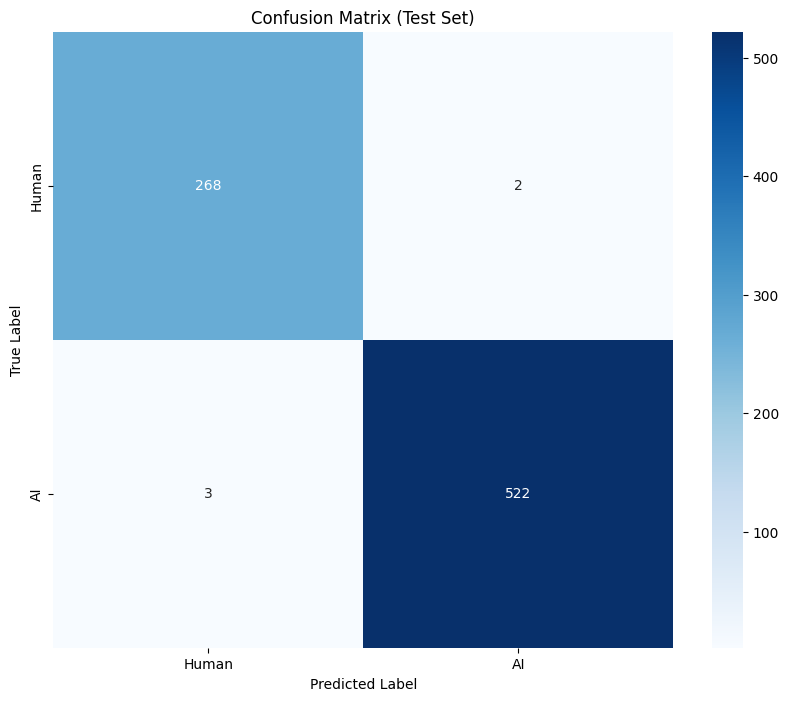

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Test Set)')
plt.savefig(f"{save_dir}/{model_name}_confusion_matrix.png")
plt.show()

In [ ]:
# Extract confusion matrix values for a results table
correct_human = cm[0][0]  # True negative
incorrect_human = cm[0][1]  # False positive
correct_ai = cm[1][1]  # True positive
incorrect_ai = cm[1][0]  # False negative

# Create a results table similar to the one shown
results_table = pd.DataFrame({
    "Class": ["Human", "AI"],
    "Correct Predictions": [correct_human, correct_ai],
    "Misclassifications": [incorrect_human, incorrect_ai]
})

print("\nClassification Results:")
print(results_table)


Classification Results:
   Class  Correct Predictions  Misclassifications
0  Human                  268                   2
1     AI                  522                   3


In [ ]:
# Calculate class-specific accuracy metrics
human_accuracy = correct_human / (correct_human + incorrect_human)
ai_accuracy = correct_ai / (correct_ai + incorrect_ai)
overall_accuracy = (correct_human + correct_ai) / (correct_human + correct_ai + incorrect_human + incorrect_ai)

print(f"\nHuman Detection Accuracy: {human_accuracy:.4f}")
print(f"AI Detection Accuracy: {ai_accuracy:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Analyze performance by model type
print("\nPerformance by Model Type:")
model_performance = {}

# Create test_df with predictions
test_df_with_preds = test_df.copy()
test_df_with_preds['prediction'] = test_preds

# Calculate accuracy for each model type
for model_name in test_df_with_preds['model'].unique():
    model_df = test_df_with_preds[test_df_with_preds['model'] == model_name]
    model_acc = accuracy_score(model_df['label'], model_df['prediction'])
    model_count = len(model_df)
    model_performance[model_name] = {"accuracy": model_acc, "count": model_count}

# Convert to DataFrame for nice display
model_df = pd.DataFrame.from_dict(model_performance, orient='index')
model_df = model_df.sort_values("accuracy", ascending=False)
print(model_df)

# Save training logs
training_logs = pd.DataFrame(trainer.state.log_history)
training_logs.to_csv(f"{save_dir}/{model_name}_training_log.csv", sep='\t')


Human Detection Accuracy: 0.9926
AI Detection Accuracy: 0.9943
Overall Accuracy: 0.9937

Performance by Model Type:
              accuracy  count
gpt3          1.000000     33
cohere        1.000000     35
gpt2          1.000000     64
chatgpt       1.000000     32
gpt4          1.000000     26
cohere-chat   1.000000     40
mistral-chat  1.000000     54
mpt-chat      1.000000     73
llama-chat    1.000000     58
human         0.992593    270
mistral       0.981818     55
mpt           0.963636     55





*   Human Detection Accuracy: 99.26% (up from ~16.8% originally)
*   AI Detection Accuracy: 99.43% (maintained from ~97.3% originally)
*   Human False Positive Rate: 0.74% - Only 2 out of 270 human texts misclassified

Citation

In [ ]:
@inproceedings{dugan-etal-2024-raid,
    title = "{RAID}: A Shared Benchmark for Robust Evaluation of Machine-Generated Text Detectors",
    author = "Dugan, Liam  and
      Hwang, Alyssa  and
      Trhl{\'\i}k, Filip  and
      Zhu, Andrew  and
      Ludan, Josh Magnus  and
      Xu, Hainiu  and
      Ippolito, Daphne  and
      Callison-Burch, Chris",
    booktitle = "Proceedings of the 62nd Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)",
    month = aug,
    year = "2024",
    address = "Bangkok, Thailand",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2024.acl-long.674",
    pages = "12463--12492",
}